In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random, math


####Parameters####
C = 100 #constant to change the penalty
P = 3 #Degree of polynomial kernel
SIGMA =1 #Kernel width for RBF
OPTION = 'RBF' #Kernel options: 'LIN', 'POLY', 'RBF'


####Only for being declared ####

N = None #Number of datapoints
P_IJ = None #Matrix of datapoints
START = None
TARGETS = None
INPUTS = None
BIAS = None
SUPPORT_VECTORS = None
classA = None
classB = None
####Only for being declared ####  

In [5]:
def kernel(data):
    x = data[0]
    y = data[1]
    if OPTION == 'LIN':
        return np.dot(x.T, y)
    elif OPTION == 'POLY':
        return (np.dot(x.T, y) + 1) ** P
    elif OPTION == 'RBF':
        return math.exp(-np.linalg.norm(x-y)**2/(2*SIGMA**2))
    

def zerofun(alpha):
    ##Constraint function##
    return np.dot(alpha, TARGETS)

def objective(alpha):
    ##Objective function##
    outer = np.outer(alpha, alpha)
    elementwise_product = outer * P_IJ

    ##ALTERNATIVELY np.dot(alpha, np.dot(P_IJ, alpha))##

    first_term = 0.5 * np.sum(elementwise_product)
    second_term = np.sum(alpha)
    #return 0.5 * np.dot(alpha, np.dot(P, alpha)) - np.sum(alpha)
    return first_term - second_term

In [9]:
def intialize():
    global TARGETS
    global INPUTS
    global START
    global N 
    global P_IJ
    global classA
    global classB

    np.random.seed(100) #For debugging, remove later
    #classA = np.random.randn(10, 2) + [2, 2]  # Class A around (2,2)
    #classB = np.random.randn(10, 2) + [-2, -2]  # Class B around (-2,-2)
    
    # example data points
    classA = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5], np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
    classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]

    #classA = np.concatenate((
    #    np.random.randn(10, 2) * 0.6 + [1.5, 0.5],   # Cluster around (1.5, 0.5)
    #    np.random.randn(10, 2) * 0.6 + [-1.5, 0.5]   # Cluster around (-1.5, 0.5)
    #))
#
    #classB = np.random.randn(20, 2) * 1 + [0.0, -0.5]  # Cluster around (0.0, -0.5)




    inputs = np.concatenate((classA, classB))
    targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))
    N = inputs.shape[0]
    permute = list(range(N))
    random.shuffle(permute)
    INPUTS = inputs[permute,:]
    TARGETS = targets[permute]
    START = np.zeros(N)

    ##Buld the matrix P_IJ##
    P_IJ = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            P_IJ[i,j] = kernel([INPUTS[i], INPUTS[j]])*TARGETS[i]*TARGETS[j]

Optimization successful
nr of support vectors:  4


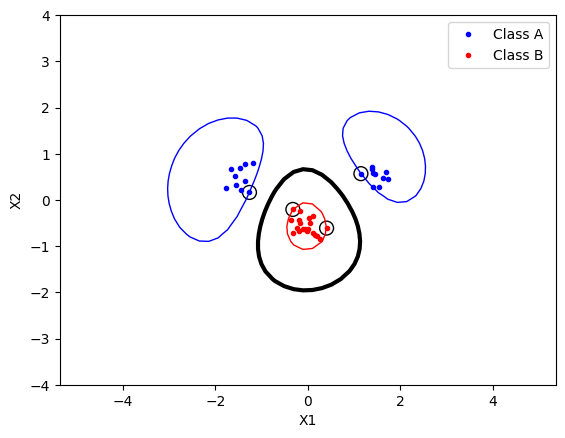

In [10]:
def main():
    global BIAS
    global SUPPORT_VECTORS
    intialize()
    constraint={'type':'eq', 'fun':zerofun}
    Bounds = [(0,C) for b in range (N)]
    print
    ret = minimize(objective, START, bounds=Bounds, constraints=constraint)
    alpha_vec = ret['x']
    if ret['success']:
        print("Optimization successful")
        #print('ALPHA: ', alpha_vec)
        #print(len(alpha_vec))
    else:
        print("Optimization failed")

    #Extract non-zero alphas with corresponding inputs and targets
    SUPPORT_VECTORS = [(alpha, INPUTS[index,:], TARGETS[index]) for index,alpha in enumerate(alpha_vec) if alpha > 10e-5]
    print('nr of support vectors: ', len(SUPPORT_VECTORS))

    #bias calculation
    bias = []
    for sv in SUPPORT_VECTORS:
        sum = 0
        for point in SUPPORT_VECTORS:
            sum += point[0] * point[2] * kernel([sv[1], point[1]])

        bias.append(sum - sv[2])
    BIAS = np.mean(np.array(bias))
    #print('BIAS: ', BIAS)
    plot()

def indicator(point):
    sum = 0
    for sv in SUPPORT_VECTORS:
        sum += sv[0] * sv[2] * kernel([point, sv[1]])
    return sum - BIAS

def plot():
    plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
    plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
    plt.scatter([p[1][0] for p in SUPPORT_VECTORS], [p[1][1] for p in SUPPORT_VECTORS], edgecolor='black', facecolor='none', s=100) #Support vectors
    plt.axis('equal')
    plt.legend(['Class A', 'Class B'])
    plt.xlabel('X1')
    plt.ylabel('X2')


    xgrid = np.linspace(-5, 5)
    ygrid = np.linspace(-4, 4)
    grid = np.array([[indicator(np.array([x, y])) for x in xgrid] for y in ygrid])
    plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1,3,1))
    plt.savefig('rbf_1.png')
    plt.show()

    
### Remember to make x,y points ina  np.array when calling indicator!!!
if __name__ == "__main__":
    main()


----------------------

#### Dual form of svm optimization problem

![Alternative Text](dual_optimization.png)

- alpha: the Lagrange multiplier

1. each training data point xi has a corresponding alpha
2. the svm optimization problem tries to find the set of alphai that maximize the margin while satisfying the constraints
3. only support vectors have non-zero alpha


#### zero function:
1. it is the constraint that svm dual optimization problem includes

<img src="zero_function.png" width="300" alt = "formula">

2. it ensures that the support vectors are properly balanced between the 2 classes

3. `"type":"eq"` specifies an equality constraint of the form: constraint(x) = 0
4. `"fun":zerofun` tells the optimizer to use the zerofun function to check if the constraint is satisfied

- bias

1. the bias shifts the decision boundary so that the classifier aligns correctly with the training data
2. the bias ensures that the decision boundary satisfies: `f(xi)=ti` for support vectors

- bounds

![bounds](bound.png)

1. it sets limits on the values of the alpha
2. each alpha i is constrainted to be between 0 and C

2.1. when alpha = 0, the point is not a support vector

2.2. when alpha = C, the point lies inside the margin (slack allowed)

2.3. intermediate values means support vectors on the boundary


-----------------

### Linear separable

**using generated simple datapoints we can use linera kernel to easily separate between 2 calsses**

![linear_sep](linear_sep.png)

### Q1 & Q2 : Linear Kernel Failed  (provided data)
`1. The clusters were moved and spread out more to make it more difficult to find a linear separation between the classes  `


**Because there is no clear veritcal or horisontal separation between the two classes the Linear Kernel fails to find a decision line**

![linear_kernel](linear_kernel.png)

**To allow for for more complex modelling of the separaition/decision line we can use kernels that project the data into higher dimensions in order to to more eaily seperate the data**

**polynomial kernel**
- degree=2

![p2](poly_2.png)

- degree=3

![p3](poly_3.png)

**RBF kernel**
- sigma = 1 

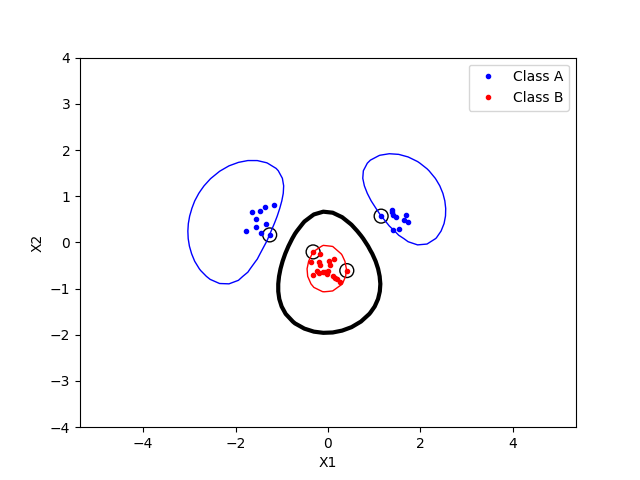

- sigma = 2

![rbf3](rbf_2.png)


### **polynomial kernel**  

![poly](poly_function.png)

- **`P` changes the degree of freedom in polynomial function**

- **variance-bias tradeoff**
1. when p is higher, the boundary gets more complex and wavy, which leads to low bias but higher variance and more possible to be overfitting
2. when p is smaller, the boundery is more simple and smooth, which leads to low variance and more generalized but high bias and more likely to be underfitting

- **examples**

1. p=2,c=1 (parabola shape)

<img src="hard_poly_d2_c1.png" width="400">



2. p=3,c=1 

<img src="hard_poly_d3_c1.png" width="400">

3. p=4,c=1

<img src="hard_poly_d4_c1.png" width="400">



### **Radial kernel**  

![rbf](rbf_function.png)

- **`sigma` defines the smoothness of the boundary**

1. sigma controls how quickly similarity decays with distance between two points

- **variance-bias tradeoff**
1. `small` sigma has a narrow peak, which means only very close points affect each other and the decision boundary becomes `highly flexible` to fit the training data, which has `low bias but high variance`, which leads to `overfitting`.

2. `large` sigma has a broad shape, which mean even distant points can influence each other and decision boundary becomes `smoother` and less sensitive to individual points, which has `low variance but high bias`, which leads to `underfitting`.

- **examples**

1. r=5,c=100

<img src="hard_rbf_r5_c100.png" width="400">

2. r=4,c=100

<img src="hard_rbf_r4_c100.png" width="400">

3. r=3,c=100

<img src="hard_rbf_r3_c100.png" width="400">

4. r=2,c=100

<img src="hard_rbf_r2_c100.png" width="400">

5. r=1,c=100

<img src="hard_rbf_r1_c100.png" width="400">

## Q4 Slack  


![constraints](constraints_slack.png)

![cost](cost_function_slack.png)

1. `||w||` controls the margin width, `minimizing` this term means `maximizing` the margin between classes
2. `ξi`​ (slack variables) allows violations of the margin (points inside margin or misclassified)
3. `C` controls the trade-off between margin size and classification error


- **`C` represents a sort of tolerance for data points which are not correctly classified**

1. higer C means ξi are `heavily penalized`, the optimizer tries to keep ξi as small as possible, which means fewer violations narrow margin, which leads to narrow boundary to avoid misclassifications 

![d=2,c=1](hard_poly_d3_c1.png)

2. lower C means `less penalized`, the model allows more points to violate the margin for a wider margin, which leads to wider decision boundary with more tolerance for misclassifications and better generalization but potentially more training errors

![d=2,c=1](hard_poly_d3_c50.png)


## Q5 Slack vs Non-linear Kernels  

when dealing with non-separable data, we have two choices (which has trade-off patterns):
- 1. increase the slack, which allows for margin violations
1. if we want better generalization rather than perfect training accuracy
2. there is more noise or outliers that we don't want them to easily affect our classifier
3. small sample size and don't want more features from a more complex kernel which leads to overfitting


- 2. use a more complex kernel, which introduce to more complex boundaries
1. the data has intrinsic non-linear patterns
2. less noise and a complex decision boundary is justified
3. high accuracy on the training data is essential

In summary, slack should be considered when splitting on noisy data, whilst RBF and POLY kernels should be considered for data that is non-linear or more complex. Often, we should use a combination of the two as no data set is completely linear or noise free. A good method for evaluating models is to use cross-validation, varying the kernels used and their respective parameters as well as the amount of slack, and choosing the combination of slack and kernel that yields the best cross-validation score. 
